# Entrance Challenge: When Will the Sakura Bloom?

***

**Name： Tuong Nguyen Van**

**Submission Date：**

***

Python 3

# 0. Basics of the Sakura Bloom-cycle (5pts total)

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.
    


### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2017 using the Japanese Meteorological Agency website (気象庁).

In [2]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta 
from functools import reduce
import math

In [41]:

# Say something. https://www.data.jma.go.jp/sakura/data/sakura003_01.html

df_web = pd.read_csv('webData.csv')
df_web['datetime'] = list(map(lambda x,y,z: datetime.date(x,y,z), df_web['year'].values, df_web['month'].values,
                                df_web['day'].values))


train_years = [1966 , 1971 , 1985 , 1994 ,2008]

df_web_train = df_web[df_web['year'].isin(train_years)]
df_web_test = df_web[~df_web['year'].isin(train_years)]
df_web_train

,year,month,day,datetime
5,1966,3,20,1966-03-20
10,1971,3,30,1971-03-30
24,1985,4,3,1985-04-03
33,1994,3,31,1994-03-31
47,2008,3,22,2008-03-22


***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

In [4]:
# Get data from tokyo.csv

df_weather = pd.read_csv("tokyo.csv")

# Add column 'datetime'
df_weather['datetime'] = list(map(lambda x,y,z: datetime.date(x,y,z), df_weather['year'].values, df_weather['month'].values,
                                df_weather['day'].values))

# Split dataset to train and test set
df_train = df_weather[df_weather['year'].isin(train_years)]
df_test = df_weather[~df_weather['year'].isin(train_years)]

df_train.head(5)

,Unnamed: 0,year,month,day,現地平均気圧,海面平均気圧,合計降水量,1時間最大降水量,10分間最大降水量,平均気温,最高気温,最低気温,平均湿度,最低湿度,日照時間,datetime
1826,1826,1966,1,1,1009.4,1013.9,0.0,0.0,0.0,3.3,7.9,-1.2,39,20,9.0,1966-01-01
1827,1827,1966,1,2,1013.8,1018.3,0.0,0.0,0.0,4.2,9.4,-0.1,37,20,9.0,1966-01-02
1828,1828,1966,1,3,1017.6,1022.1,0.0,0.0,0.0,5.5,10.7,-0.4,42,24,8.3,1966-01-03
1829,1829,1966,1,4,998.4,1002.7,22.5,9.5,2.0,3.9,7.0,2.3,74,52,0.0,1966-01-04
1830,1830,1966,1,5,995.9,1000.2,0.0,0.0,0.0,7.3,12.4,1.9,45,26,9.0,1966-01-05


In [5]:
#define plot function

def plotCumulation(array,year,ax):
    
    n_bins = 40
    
    # plot the cumulative histogram
    n, bins, patches = ax.hist(array, n_bins, density=True, histtype='step', cumulative=True, label=str(year))

    # tidy up the figure
    ax.grid(True)
    ax.legend(loc='right')
    ax.set_title('Cumulation of highest temperature ')
    ax.set_xlabel('Highest temperature (celsius degree)')
    ax.set_ylabel('Percent')

    

[607.6 663.4 677.8 656.6 596.7]
T_mean:640.4200000000001


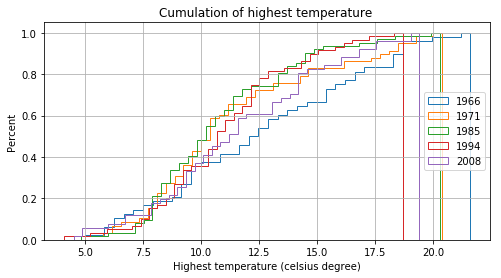

In [45]:
# Filter train set
train_600 = df_train[['year','month','day','最高気温','datetime']]
fig, ax = plt.subplots(figsize=(8, 4))
sum_arr = []
for i in train_years:
    data = train_600[train_600['year'] == i]
    
    actual_day = df_web_train[df_web_train['year'] == i]
    
    x = datetime.date(i, 2, 1)
    y = actual_day['datetime'].values[0]

    array = data[ (data['datetime'] >= x) & (data['datetime'] <= y) ]
    
    sum_arr.append(array['最高気温'].sum())
#     print(array)
#     print(array['最高気温'])
    plotCumulation(array['最高気温'].values, i, ax)
plt.show
np_sum_arr = np.array(sum_arr)
t_mean = np.average(np_sum_arr)
print(np_sum_arr)
print ("T_mean:" + str(t_mean))


##### $T_{mean}$ = 640.42 
##### We should't use 600$^\circ$C as a rule for Tokyo.

### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

In [7]:
# Get data
test_1_2 = df_test[['year','month','day','最高気温','datetime']]
test_years = set(test_1_2['year'].values)


In [8]:
# define the function that predicting BD and count the number of day from Feb, 1st to BD
def prob1_2_a(threshold):
    pred_data = {}
    for i in test_years:
        x = datetime.date(i, 2, 1)
        data = test_1_2[(test_1_2['year'] == i) & (test_1_2['datetime'] >= x)]
        sum = 0
        count = 0
        for index, row in data.iterrows():
            sum += row['最高気温']
            count += 1
            if sum > threshold:
                #return dict{year: [sum-of-temp, BD, count]}
                pred_data.update({i:[sum, row['datetime'],count]})
                break
    return pred_data


In [46]:
# number of days from Feb, 1st to actual-bloom day
y_actual = []
for i in test_years:
    x = datetime.date(i, 2, 1)
    actual_day = df_web_test[df_web_test['year'] == i]
    y = actual_day['datetime'].values[0]
    data = test_1_2[(test_1_2['datetime'] >= x) & (test_1_2['datetime'] <= y)]
    y_actual.append(len(data.index))
print(y_actual)

[60, 60, 60, 62, 61, 58, 58, 65, 66, 57, 59, 61, 57, 51, 50, 59, 51, 60, 54, 51, 59, 71, 62, 51, 62, 48, 48, 58, 53, 52, 59, 60, 49, 55, 52, 59, 51, 44, 55, 47, 59, 49, 48, 49, 50, 56, 60, 44, 53, 51, 50, 49]


In [10]:
# define R score function
def r_square(y_actual, y_pred):
    y_actual = np.array(y_actual)
    y_pred = np.array(y_pred)
    y_mean = np.average(y_actual)
    ss_res = np.sum((y_pred - y_actual)**2)
    ss_tot = np.sum((y_actual - y_mean)**2)
    return 1 - ss_res/ss_tot


In [11]:
y_pred_600 = []
for i in prob1_2_a(600).items():
    y_pred_600.append(i[1][2])
print(y_pred_600)

y_pred_t_mean = []
for i in prob1_2_a(t_mean).items():
    y_pred_t_mean.append(i[1][2])
print(y_pred_t_mean)

[53, 47, 55, 59, 59, 55, 54, 57, 59, 57, 53, 58, 57, 52, 53, 57, 49, 58, 54, 53, 54, 69, 61, 52, 58, 50, 50, 52, 52, 52, 53, 56, 49, 50, 49, 54, 50, 45, 55, 46, 54, 51, 47, 48, 51, 53, 58, 47, 53, 50, 47, 48]
[56, 50, 57, 61, 61, 57, 58, 60, 63, 59, 56, 60, 59, 55, 56, 60, 52, 60, 57, 56, 58, 71, 63, 55, 62, 53, 52, 55, 55, 54, 56, 59, 52, 53, 52, 57, 52, 47, 58, 49, 57, 54, 50, 51, 55, 56, 60, 49, 55, 53, 50, 51]


In [12]:
print(r_square(y_actual, y_pred_600 ))
print(r_square(y_actual, y_pred_t_mean ))

0.5841220511371663
0.7219946320101709


***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.


### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

In [13]:
df_first_3mon = df_weather[['year','month','平均気温','datetime']]
df_first_3mon = df_first_3mon[df_first_3mon['month'].isin([1,2,3])]
prob2_1_year = set(df_first_3mon['year'].values)
tf = {}
for i in prob2_1_year:
    data = df_first_3mon[df_first_3mon['year'] == i]
    tf.update({i:[data['平均気温'].mean()]})
tf    # Average of location's average temperature [°C] over the first 3 months of a given year

{1961: [5.471111111111112],
 1962: [6.254444444444444],
 1963: [5.2155555555555555],
 1964: [5.752747252747253],
 1965: [5.354444444444445],
 1966: [7.138888888888889],
 1967: [6.334444444444443],
 1968: [6.740659340659341],
 1969: [6.438888888888887],
 1970: [5.3355555555555565],
 1971: [6.445555555555556],
 1972: [7.164835164835163],
 1973: [6.985555555555558],
 1974: [5.601111111111111],
 1975: [5.908888888888888],
 1976: [7.037362637362637],
 1977: [5.9188888888888895],
 1978: [6.2299999999999995],
 1979: [8.307777777777778],
 1980: [6.364835164835165],
 1981: [6.262222222222222],
 1982: [7.082222222222222],
 1983: [6.983333333333333],
 1984: [4.246153846153846],
 1985: [6.110000000000001],
 1986: [5.5488888888888885],
 1987: [7.328888888888889],
 1988: [7.035164835164834],
 1989: [8.413333333333332],
 1990: [7.797777777777778],
 1991: [7.487777777777778],
 1992: [7.810989010989011],
 1993: [7.5200000000000005],
 1994: [6.727777777777779],
 1995: [7.2411111111111115],
 1996: [7.093

In [14]:
# define D_j function
def D_j(tf):
    phi = 107/3       # = 35*40'
    l = 4
    return 136.75 - 7.689*phi + 0.133*(phi**2) - 1.307*(math.log(l)) + 0.144*tf + 0.285*(tf**2)


In [15]:
for i in tf.items():
    i[1].append(D_j(i[1][0]))
tf     # Append D_j

{1961: [5.471111111111112, 39.20665223297926],
 1962: [6.254444444444444, 41.937182510757026],
 1963: [5.2155555555555555, 38.3915066774237],
 1964: [5.752747252747253, 40.14810542407713],
 1965: [5.354444444444445, 38.82990251075704],
 1966: [7.138888888888889, 45.44055539964592],
 1967: [6.334444444444443, 42.23572917742369],
 1968: [6.740659340659341, 43.807945171692154],
 1969: [6.438888888888887, 42.63098873297925],
 1970: [5.3355555555555565, 38.7696346774237],
 1971: [6.445555555555556, 42.6564291774237],
 1972: [7.164835164835163, 45.55006324921901],
 1973: [6.985555555555558, 44.80123717742371],
 1974: [5.601111111111111, 39.63559806631259],
 1975: [5.908888888888888, 40.689536899645915],
 1976: [7.037362637362637, 45.01574604115236],
 1977: [5.9188888888888895, 40.724686066312586],
 1978: [6.2299999999999995, 41.84668754779407],
 1979: [8.307777777777778, 50.75467495520148],
 1980: [6.364835164835165, 42.35009841405418],
 1981: [6.262222222222222, 41.96604778853481],
 1982: [

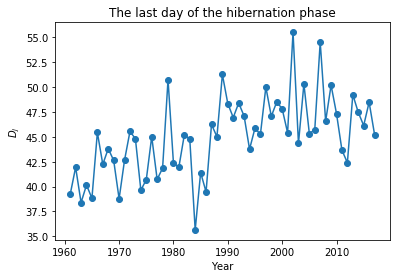

In [16]:
x = [i[0] for i in tf.items()]
y = [i[1][1] for i in tf.items()]
plt.plot(x, y,'o-')
plt.xlabel('Year')
plt.ylabel(r'$D_j$')
plt.title('The last day of the hibernation phase')
plt.show()

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 


In [17]:
def J(E_a):
    return E_a*4184

def DTS(E_a, np_t_ij):
    np_t_ij = np.exp((J(E_a)*(np_t_ij-17)) / (8.314*((np_t_ij + 274.15)*(17 + 274.15))))
    return np.sum(np_t_ij)


In [47]:
E_a = [i for i in range(5,41)]
df_prob2_2 = df_train[['year','month','day','平均気温','datetime']]
DTS_dict = {}
for i in E_a:
    DTS_dict.update({i:[]})
    for year in train_years:
        data = df_prob2_2[df_prob2_2['year'] == year]
        
        actual_day = df_web_train[df_web_train['year'] == year]
        y = actual_day['datetime'].values[0]
        Dj = datetime.date(year,1,1)+ timedelta(days=(math.floor(tf[year][1])))
        data = data[(data['datetime'] >= Dj) & (data['datetime'] <= y)]
        DTS_dict[i].append([year,DTS(i,data['平均気温'].values)])
DTS_dict

{5: [[1966, 26.73941212873357],
  [1971, 35.56861087827697],
  [1985, 38.794862310822474],
  [1994, 35.37049014624665],
  [2008, 28.16469079970057]],
 6: [[1966, 25.518517805041558],
  [1971, 33.69059960150165],
  [1985, 36.61865345537512],
  [1994, 33.43263153229508],
  [2008, 26.841973678479814]],
 7: [[1966, 24.36397644332804],
  [1971, 31.928027476687596],
  [1985, 34.57487562885979],
  [1994, 31.60632529094916],
  [2008, 25.589837769969535]],
 8: [[1966, 23.271781606737804],
  [1971, 30.273257079991623],
  [1985, 32.65513086078545],
  [1994, 29.884883822607833],
  [2008, 24.40419334798717]],
 9: [[1966, 22.238185511477777],
  [1971, 28.719179717142502],
  [1985, 30.851570475104566],
  [1994, 28.26203503145322],
  [2008, 23.28120183935527]],
 10: [[1966, 21.259681549781376],
  [1971, 27.25917760889806],
  [1985, 29.15685819289179],
  [1994, 26.73189563377142],
  [2008, 22.217259698382545]],
 11: [[1966, 20.33298803346634],
  [1971, 25.887088850509688],
  [1985, 27.564135774202537],

In [48]:
DTS_mean = {}
for index,value in DTS_dict.items():
    arr = []
    for i in value:
        arr.append(i[1])
    DTS_mean.update({index:(sum(arr)/len(arr))})
DTS_mean

{5: 32.927613252756046,
 6: 31.220475214538645,
 7: 29.612608521958826,
 8: 28.097849343621977,
 9: 26.670434514906667,
 10: 25.32497453674504,
 11: 24.056428450034655,
 12: 22.86008045190822,
 13: 21.731518129854553,
 14: 20.666612198722746,
 15: 19.661497634007386,
 16: 18.712556102556597,
 17: 17.81639959901414,
 18: 16.96985520294472,
 19: 16.169950877738884,
 20: 15.413902238086582,
 21: 14.699100218081844,
 22: 14.023099576905702,
 23: 13.38360818356021,
 24: 12.778477026320212,
 25: 12.205690896455444,
 26: 11.663359699377818,
 27: 11.149710349707354,
 28: 10.66307920984578,
 29: 10.201905034516747,
 30: 9.764722386393073,
 31: 9.350155490399686,
 32: 8.956912496570517,
 33: 8.583780123461393,
 34: 8.229618656091619,
 35: 7.893357274215414,
 36: 7.573989688421366,
 37: 7.270570063133016,
 38: 6.9822092070458766,
 39: 6.708071012893525,
 40: 6.447369129695858}

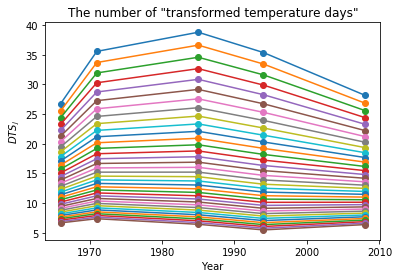

In [49]:
for index,value in DTS_dict.items():
    plt.plot([i[0] for i in value],[i[1] for i in value],'o-')

plt.xlabel('Year')
plt.ylabel(r'$DTS_j$')
plt.title('The number of "transformed temperature days"')

plt.show()

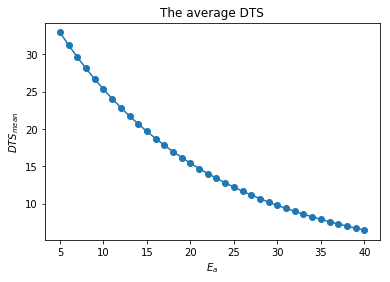

In [50]:


plt.plot([i for i,v in DTS_mean.items()],[v for i,v in DTS_mean.items()],'o-')

plt.xlabel(r'$E_{a}$')
plt.ylabel(r'$DTS_{mean}$')
plt.title('The average DTS')

plt.show()

### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

In [51]:
prob2_3_pred = {}
for i in E_a:
    prob2_3_pred.update({i:[]})
    for year in train_years:
        data = df_prob2_2[df_prob2_2['year'] == year]
        Dj = datetime.date(year,1,1)+ timedelta(days=(math.floor(tf[year][1])))
        data = data[(data['datetime'] >= Dj)]
        arr = []
        for index, row in data.iterrows():
            arr.append(row['平均気温'])
            if DTS(i,np.array(arr)) > DTS_mean[i]:
                prob2_3_pred[i].append([year,row['datetime']])
                break
prob2_3_pred


{5: [[1966, datetime.date(1966, 3, 28)],
  [1971, datetime.date(1971, 3, 28)],
  [1985, datetime.date(1985, 3, 27)],
  [1994, datetime.date(1994, 3, 29)],
  [2008, datetime.date(2008, 3, 28)]],
 6: [[1966, datetime.date(1966, 3, 28)],
  [1971, datetime.date(1971, 3, 28)],
  [1985, datetime.date(1985, 3, 28)],
  [1994, datetime.date(1994, 3, 29)],
  [2008, datetime.date(2008, 3, 28)]],
 7: [[1966, datetime.date(1966, 3, 28)],
  [1971, datetime.date(1971, 3, 28)],
  [1985, datetime.date(1985, 3, 28)],
  [1994, datetime.date(1994, 3, 29)],
  [2008, datetime.date(2008, 3, 27)]],
 8: [[1966, datetime.date(1966, 3, 28)],
  [1971, datetime.date(1971, 3, 28)],
  [1985, datetime.date(1985, 3, 28)],
  [1994, datetime.date(1994, 3, 29)],
  [2008, datetime.date(2008, 3, 27)]],
 9: [[1966, datetime.date(1966, 3, 27)],
  [1971, datetime.date(1971, 3, 28)],
  [1985, datetime.date(1985, 3, 29)],
  [1994, datetime.date(1994, 3, 29)],
  [2008, datetime.date(2008, 3, 27)]],
 10: [[1966, datetime.date(196

In [73]:
prob2_3_mean = {}

for index,value in prob2_3_pred.items():
    
    prob2_3_mean.update({index:[]})
    arr = []
    for i in value:
        data = df_web_train[df_web_train['year'] == i[0]]
        arr.append((data['datetime'].values[0] - i[1]).days)
    arr = np.array(arr)    
    prob2_3_mean[index].append(np.average(arr**2))
prob2_3_mean

{5: [31.4],
 6: [28.8],
 7: [26.6],
 8: [26.6],
 9: [21.4],
 10: [21.4],
 11: [19.0],
 12: [15.8],
 13: [14.0],
 14: [14.0],
 15: [13.8],
 16: [10.2],
 17: [8.8],
 18: [8.8],
 19: [6.0],
 20: [6.0],
 21: [6.2],
 22: [5.6],
 23: [5.6],
 24: [3.2],
 25: [3.2],
 26: [3.0],
 27: [3.0],
 28: [3.0],
 29: [3.0],
 30: [2.0],
 31: [2.0],
 32: [2.0],
 33: [1.4],
 34: [1.4],
 35: [1.4],
 36: [1.2],
 37: [1.2],
 38: [1.4],
 39: [1.6],
 40: [1.6]}

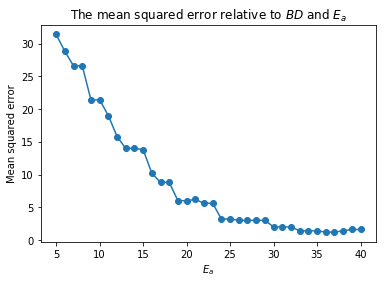

In [71]:
plt.plot([i for i,v in prob2_3_mean.items()],[v for i,v in prob2_3_mean.items()],'o-')

plt.xlabel(r'$E_{a}$')
plt.ylabel('Mean squared error')
plt.title(r'The mean squared error relative to $BD$ and $E_a$')

plt.show()

In [87]:
_min = min([v for i,v in prob2_3_mean.items()])
print(_min)
for i, v in prob2_3_mean.items():
    if v == _min:
          print( i)

[1.2]
36
37


##### $E^*_a = \{36;37\}$

### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

***
## 3. Predicting Bloom-date via Neural Network (30pts total)

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

### Problem 3-2: (10pts)
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

### Problem 4-1: (20pts)
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.